## Process dengue data 

* 
* generate list of DEG or DEP at different conditions
    * 24, 48 hrs vs control
    * 24 vs 48 hrs

* get a list of candidates for the new hypothesis generator 

In [2]:
import sys
import os

# Add the parent directory of the current script to the Python path
cwd = os.getcwd()
dirname = os.path.dirname(cwd)
print(cwd)
print(dirname)
sys.path.append(dirname)

print(sys.path)

from models.analysis_plan import AnalysisPlan
from services.analysisrunner import AnalysisRunner
from models.review_plan import ReviewPlan
from services.reviewrunner import ReviewRunner
from app.sqlite_database import SqliteDatabase
from app.config import load_database_uri

/Users/clara.h/Documents/git_src/agent_evaluation/notebooks
/Users/clara.h/Documents/git_src/agent_evaluation
['/Users/clara.h/Documents/git_src/agent_evaluation/notebooks', '/Users/clara.h/anaconda3/envs/agent_eval/lib/python311.zip', '/Users/clara.h/anaconda3/envs/agent_eval/lib/python3.11', '/Users/clara.h/anaconda3/envs/agent_eval/lib/python3.11/lib-dynload', '', '/Users/clara.h/anaconda3/envs/agent_eval/lib/python3.11/site-packages', '/Users/clara.h/anaconda3/envs/agent_eval/lib/python3.11/site-packages/setuptools/_vendor', '/Users/clara.h/Documents/git_src/agent_evaluation', '/Users/clara.h/Documents/git_src/agent_evaluation']


In [3]:
import pandas as pd
import mygene

In [14]:
#read separate sheet from excel
def read_sheet(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    return df   

# add HGNC symbols to the dataframe based on Gene ID use mygene package 

# Initialize mygene.Info
mg = mygene.MyGeneInfo()

def get_symbol_from_id(row, gene_id_column='GeneID'):
    gene_symbol_dict = mg.getgene(row[gene_id_column], fields='symbol')
    if gene_symbol_dict:
            
        if 'symbol' in gene_symbol_dict:
            return gene_symbol_dict['symbol']
        else:
            return None
    else:
        return None

In [4]:
raw_data = f'{dirname}/data/20220202_Thresholded_Datasets_DHIPC.xlsx'

protein_abundance = read_sheet(raw_data, 'ProteinAbundance')

protein_abundance['HGNC Symbol'] = protein_abundance.apply(lambda row: get_symbol_from_id(row), axis=1)

protein_abundance.head()


,Uniprot ID,Timepoint,log2FC,GeneID,HGNC Symbol
0,Q86TX2,DV3_24h-Mock_24h,1.608293,641371,ACOT1
1,Q86YS6,DV3_24h-Mock_24h,1.346686,339122,RAB43
2,Q8NFC6,DV3_48h-Mock_48h,-1.871359,259282,BOD1L1
3,Q96FN4,DV3_24h-Mock_24h,1.548070,221184,CPNE2
4,Q8IVG5,DV3_24h-Mock_24h,1.172951,219285,SAMD9L


In [13]:
protein_abundance.to_csv(f'{dirname}/data/dengue_data_protein_abundance_with_updated_symbols.csv', index=False)

In [5]:

rna_seq_24hr = read_sheet(raw_data, 'RNAseq 24hpi')
rna_seq_48hr = read_sheet(raw_data, 'RNAseq 48hpi')
rna_seq_combined = pd.concat([rna_seq_24hr, rna_seq_48hr], ignore_index=True, axis=0)
# update genen symbol to match protein abundance 
rna_seq_combined['HGNC Symbol'] = rna_seq_combined.apply(lambda row: get_symbol_from_id(row), axis=1)
rna_seq_combined.head()

,GeneSymbol,log2FC,GeneID,Condition,HGNC Symbol
0,HS3ST2,2.299718,9956,24h,HS3ST2
1,TRANK1,2.133498,9881,24h,TRANK1
2,ZBTB39,-2.249348,9880,24h,ZBTB39
3,GPRASP1,-2.175409,9737,24h,GPRASP1
4,FAM131B,-2.200291,9715,24h,FAM131B


In [11]:
rna_seq_combined.to_csv(f'{dirname}/data/dengue_data_rna_seq_with_symbols.csv', index=False)

29


In [15]:
siRNA_screen = read_sheet(raw_data, 'siRNA-Screen')
siRNA_screen['HGNC Symbol'] = siRNA_screen.apply(lambda row: get_symbol_from_id(row), axis=1)

In [22]:
siRNA_screen.loc[siRNA_screen['HGNC Symbol'].isnull(), 'HGNC Symbol'] = siRNA_screen['GeneID']
siRNA_screen.to_csv(f'{dirname}/data/dengue_data_siRNA_screen_with_symbols.csv', index=False)

In [5]:
sirna_data = pd.read_csv(f'{dirname}/data/dengue_data_siRNA_screen_with_symbols.csv')


,GeneSymbol,GeneID,Average_Zscore,HGNC Symbol
0,A2LD1,87769,1.588549,GGACT
1,ABCC2,1244,1.209934,ABCC2
2,ABCG2,9429,1.293657,ABCG2
3,ACACB,32,1.126954,ACACB
4,ACAS2L,84532,1.994937,ACSS1
...,...,...,...,...
1058,ZNF704,619279,1.356330,ZNF704
1059,ZNF708,7562,1.527764,ZNF708
1060,ZNRF3,84133,1.363028,ZNRF3
1061,ZSIG11,51368,1.436758,TEX264


## load the Protein abundance data 

In [6]:
protein_abundance = pd.read_csv(f'{dirname}/data/dengue_data_protein_abundance_with_updated_symbols.csv')
abundance_df = protein_abundance.pivot(index=['HGNC Symbol', 'GeneID', 'Uniprot ID'], columns='Timepoint', values='log2FC').reset_index()
abundance_df.columns.name = None
abundance_df = abundance_df.rename_axis(None, axis=1)
abundance_df= abundance_df.rename(
    columns={'DV3_24h-Mock_24h': 'protein_abundance_log2FC_24h', 'DV3_48h-Mock_48h': 'protein_abundance_log2FC_48h'}
)

abundance_df.head()


,HGNC Symbol,GeneID,Uniprot ID,protein_abundance_log2FC_24h,protein_abundance_log2FC_48h
0,A2M,2,P01023,NaN,-2.371772
1,ABCD3,5825,P28288,NaN,0.994370
2,ACOT1,641371,Q86TX2,1.608293,NaN
3,AGL,178,P35573,-1.062767,NaN
4,ATG7,10533,O95352,NaN,-1.628837


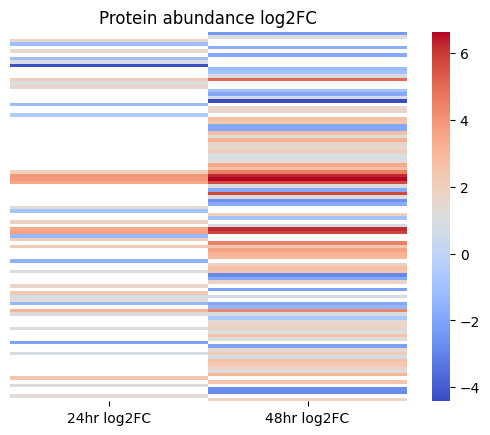

In [6]:
# plot heatmap protein abundance for 24 and 48 hr
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(abundance_df[['protein_abundance_log2FC_24h', 'protein_abundance_log2FC_48h']], annot=False, cmap='coolwarm')
#remove y ticks
plt.yticks([])
#rename x ticks
plt.xticks(ticks=[0.5, 1.5], labels=['24hr log2FC', '48hr log2FC'], rotation=0)
plt.title('Protein abundance log2FC')
plt.show()

In [16]:
# set log2FC threshold for protein abundance
log2fc_threshold = 2
upregulated_proteins_24hr = abundance_df[(abundance_df['protein_abundance_log2FC_24h'] > log2fc_threshold)]
upregulated_proteins_48hr = abundance_df[(abundance_df['protein_abundance_log2FC_48h'] > log2fc_threshold)]
print(f'Number of upregulated proteins at 24hr: {upregulated_proteins_24hr.shape[0]}')
print(f'Number of upregulated proteins at 48hr: {upregulated_proteins_48hr.shape[0]}')

downregulated_proteins_24hr = abundance_df[(abundance_df['protein_abundance_log2FC_24h'] < -log2fc_threshold)]
downregulated_proteins_48hr = abundance_df[(abundance_df['protein_abundance_log2FC_48h'] < -log2fc_threshold)]
print(f'Number of downregulated proteins at 24hr: {downregulated_proteins_24hr.shape[0]}')
print(f'Number of downregulated proteins at 48hr: {downregulated_proteins_48hr.shape[0]}')


Number of upregulated proteins at 24hr: 12
Number of upregulated proteins at 48hr: 30
Number of downregulated proteins at 24hr: 2
Number of downregulated proteins at 48hr: 8


In [17]:
# create 7 new dataframes for upregulated and downregulated proteins at 24 and 48 hr, only proteins with HGNC symbols 
upregulated_proteins_24hr = upregulated_proteins_24hr[['HGNC Symbol']]
upregulated_proteins_24hr.columns = ['Upregulated Proteins at 24hr']
upregulated_proteins_24hr.to_csv(f'{dirname}/data/dengue_protein_abundance/upregulated_proteins_24hr.csv', index=False)

downregulated_proteins_24hr = downregulated_proteins_24hr[['HGNC Symbol']]
downregulated_proteins_24hr.columns = ['Downregulated Proteins at 24hr']
downregulated_proteins_24hr.to_csv(f'{dirname}/data/dengue_protein_abundance/downregulated_proteins_24hr.csv', index=False)

concat_24hr_DEP = pd.concat([upregulated_proteins_24hr, downregulated_proteins_24hr], axis=1)
concat_24hr_DEP.to_csv(f'{dirname}/data/dengue_protein_abundance/DEP_at_24hr.csv', index=False)

upregulated_proteins_48hr = upregulated_proteins_48hr[['HGNC Symbol']]
upregulated_proteins_48hr.columns = ['Upregulated Proteins at 48hr']
upregulated_proteins_48hr.to_csv(f'{dirname}/data/dengue_protein_abundance/upregulated_proteins_48hr.csv', index=False)

downregulated_proteins_48hr = downregulated_proteins_48hr[['HGNC Symbol']]
downregulated_proteins_48hr.columns = ['Downregulated Proteins at 48hr']
downregulated_proteins_48hr.to_csv(f'{dirname}/data/dengue_protein_abundance/downregulated_proteins_48hr.csv', index=False)

concat_48hr_DEP = pd.concat([upregulated_proteins_48hr, downregulated_proteins_48hr], axis=1)   
concat_48hr_DEP.to_csv(f'{dirname}/data/dengue_protein_abundance/DEP_at_48hr.csv', index=False)

In [18]:
concat_all_DEP = pd.concat([concat_24hr_DEP, concat_48hr_DEP], axis=1)
concat_all_DEP.to_csv(f'{dirname}/data/dengue_protein_abundance/DEP_24_28hr_together.csv', index=False)
concat_all_DEP.head()

,Upregulated Proteins at 24hr,Downregulated Proteins at 24hr,Upregulated Proteins at 48hr,Downregulated Proteins at 48hr
13,CMPK2,NaN,CMPK2,NaN
39,IFIH1,NaN,IFIH1,NaN
40,IFIT1,NaN,IFIT1,NaN
41,IFIT2,NaN,IFIT2,NaN
42,IFIT3,NaN,IFIT3,NaN


In [11]:
# merge siRNA and protein abundance data into one dataframe
merged = pd.merge(sirna_data, abundance_df, on=['HGNC Symbol', 'GeneID'], how='outer')
# remove geneSymbol and uniprot ID 
merged = merged.drop(['GeneSymbol', 'Uniprot ID'], axis=1)
merged = merged[['HGNC Symbol', 'GeneID', 'Average_Zscore', 'protein_abundance_log2FC_24h', 'protein_abundance_log2FC_48h']]
merged.rename(columns={'Average_Zscore': 'siRNA_Average_Zscore'}, inplace=True)
merged.to_csv(f'{dirname}/data/dengue_siRNA_and_protein_abundance.csv', index=False)


In [ ]:
# filter for DEPs
